### Download data from AWS RDS to DataFrame

In [1]:
# import dependencies

import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [2]:
# Database engine to connect with AWS RDS

dialect = 'postgresql'
username = 'postgres'
password = 'bootcamp2021'
host = 'bootcamp-final-cln.ch1wrcuq3max.us-east-2.rds.amazonaws.com'
database = 'crime'
engine = create_engine(f'{dialect}://{username}:{password}@{host}/{database}')

In [3]:
# upload additional tables

# gdp_file = os.path.join('..', 'Data', 'GDP_by_State_2020.csv')
# pd.read_csv(gdp_file).to_sql(name='gpd_by_state_2020', con=engine, if_exists='replace')

# state_size_file = os.path.join('..', 'Data', 'Size_State.csv')
# pd.read_csv(state_size_file).to_sql(name='state_size', con=engine, if_exists='replace')


In [4]:
# list all the tables on the AWS RDS

inspector = inspect(engine)
inspector.get_table_names()

['offense_cat_offender_race_2020',
 'offense_cat_offender_sex_2020',
 'offense_cat_type_2020',
 'offense_cat_victim_age_2020',
 'offense_cat_victim_race_2020',
 'offense_cat_victim_sex_2020',
 'state_pop_agencies_2020',
 'gpd_by_state_2020',
 'state_size',
 'offense_cat_loc_2020',
 'offense_cat_state_2020',
 'law_enforcement_state_2020',
 'law_enforcement_state_city_2020',
 'offense_cat_offender_age_2020']

In [5]:
# download tables from AWS RDS

with engine.connect() as conn:
    crime_type_df = pd.read_sql("SELECT * FROM offense_cat_type_2020", conn)
    crime_df = pd.read_sql("SELECT * FROM offense_cat_state_2020", conn)
    law_enforcement_df = pd.read_sql("SELECT * FROM law_enforcement_state_2020", conn)
    gdp_df = pd.read_sql("SELECT * FROM gpd_by_state_2020", conn)
    state_size_df = pd.read_sql("SELECT * FROM state_size", conn)

### Sum the number of crimes for each state and group by "Offense_Type". This DataFrame is displayed as a heatmap on the webpage.

In [6]:
# add a column of 'Offense_Type' to the crime_df

for i in range(len(crime_df)):
    for j in range(len(crime_type_df)):
        if crime_df.loc[i, 'Offense_Category'] == crime_type_df.loc[j, 'Offense_Category']:
            crime_df.loc[i, 'Offense_Type'] = crime_type_df.loc[j, 'Offense_Type']

crime_df.head()

,State,Offense_Category,Volume,Offense_Type
0,Alabama,Assault,4214,Person
1,Alabama,Homicide,24,Person
2,Alabama,Human Trafficking,0,Person
3,Alabama,Kidnapping_Abduction,52,Person
4,Alabama,Sex,94,Person


In [7]:
# make sure no NaN

crime_df.isna().sum()

State               0
Offense_Category    0
Volume              0
Offense_Type        0
dtype: int64

In [8]:
# group DataFrame by 'Offense_Type' and 'State'

crime_by_state_df = pd.DataFrame()
crime_by_state_df['Total_crimes'] = crime_df.groupby(['State']).sum()
crime_by_state_df['Crime_against_person'] = crime_df[crime_df['Offense_Type']=='Person'].groupby(['State']).sum()
crime_by_state_df['Crime_against_property'] = crime_df[crime_df['Offense_Type']=='Property'].groupby(['State']).sum()
crime_by_state_df['Crime_against_society'] = crime_df[crime_df['Offense_Type']=='Society'].groupby(['State']).sum()
crime_by_state_df.head()

,Total_crimes,Crime_against_person,Crime_against_property,Crime_against_society
State,,,,
Alabama,15600,4384,7981,3235
Arizona,83963,18440,47284,18239
Arkansas,235122,63893,135509,35720
Colorado,353126,64221,257623,31282
Connecticut,116810,27833,78197,10780


## Pre-processing the dataset

In [9]:
# Convert data type of "2020_Sum" from string to int for the gdp_df dataframe

if gdp_df['2020_Sum'].dtypes != 'int32':
    gdp_df['2020_Sum'] = gdp_df['2020_Sum'].map(lambda x: float(''.join(x.split(',')))).astype(int)

# Convert data type of "State Area (Square Miles)" from string to int for the state_size_df dataframe

if state_size_df['State Area (Square Miles)'].dtypes != 'int32':
    state_size_df['State Area (Square Miles)'] = state_size_df['State Area (Square Miles)'].map(lambda x: float(''.join(x.split(',')))).astype(int)

In [10]:
# merge the DataFrames based on "State"

df = crime_by_state_df.merge(law_enforcement_df, how='inner', on='State')\
                      .merge(gdp_df, how='inner', on='State')\
                      .merge(state_size_df, how='inner', on='State')

# rename 'Est_pop' to 'population'
df['population'] = df['Est_pop']

In [11]:
# Normalize features of interest based on the state's population and add new features

df['total_crimes_per_capita'] = df['Total_crimes'] / df['population']
df['person_crimes_per_capita'] = df['Crime_against_person'] / df['population']
df['property_crimes_per_capita'] = df['Crime_against_property'] / df['population']
df['society_crimes_per_capita'] = df['Crime_against_society'] / df['population']
df['total_law_per_capita'] = df['Total_law_ employees'] / df['population']
df['male_officers_per_capita'] = df['male_officers'] / df['population']
df['female_officers_per_capita'] = df['female_officers'] / df['population']
df['gdp_per_capita'] = df['2020_Sum'] / df['population']
df['state_size_per_capita'] = df['State Area (Square Miles)'] / df['population']

df.head()

,State,Total_crimes,Crime_against_person,Crime_against_property,Crime_against_society,Total_law_ employees,male_officers,female_officers,male_civilians,female_civilians,...,population,total_crimes_per_capita,person_crimes_per_capita,property_crimes_per_capita,society_crimes_per_capita,total_law_per_capita,male_officers_per_capita,female_officers_per_capita,gdp_per_capita,state_size_per_capita
0,Alabama,15600,4384,7981,3235,17985,11203,1014,2003,3765,...,4851203,0.003216,0.000904,0.001645,0.000667,0.003707,0.002309,0.000209,0.187085,0.010461
1,Arizona,83963,18440,47284,18239,22526,11308,1450,4485,5283,...,7359580,0.011409,0.002506,0.006425,0.002478,0.003061,0.001537,0.000197,0.203120,0.015441
2,Arkansas,235122,63893,135509,35720,10442,6087,724,1375,2256,...,3011972,0.078062,0.021213,0.044990,0.011859,0.003467,0.002021,0.000240,0.173641,0.017289
3,Colorado,353126,64221,257623,31282,18853,10801,1885,2260,3907,...,5753378,0.061377,0.011162,0.044778,0.005437,0.003277,0.001877,0.000328,0.265989,0.018029
4,Connecticut,116810,27833,78197,10780,9163,6814,892,595,862,...,3557006,0.032839,0.007825,0.021984,0.003031,0.002576,0.001916,0.000251,0.310849,0.001362


In [12]:
# select features of interest

columns_to_keep = [ 'State',
                    'population',
                    'total_crimes_per_capita',
                    'person_crimes_per_capita',
                    'property_crimes_per_capita',
                    'society_crimes_per_capita',
                    'total_law_per_capita',
                    'male_officers_per_capita',
                    'female_officers_per_capita',
                    'gdp_per_capita',
                    'state_size_per_capita']

featured_df = df[columns_to_keep]
featured_df.head()

,State,population,total_crimes_per_capita,person_crimes_per_capita,property_crimes_per_capita,society_crimes_per_capita,total_law_per_capita,male_officers_per_capita,female_officers_per_capita,gdp_per_capita,state_size_per_capita
0,Alabama,4851203,0.003216,0.000904,0.001645,0.000667,0.003707,0.002309,0.000209,0.187085,0.010461
1,Arizona,7359580,0.011409,0.002506,0.006425,0.002478,0.003061,0.001537,0.000197,0.203120,0.015441
2,Arkansas,3011972,0.078062,0.021213,0.044990,0.011859,0.003467,0.002021,0.000240,0.173641,0.017289
3,Colorado,5753378,0.061377,0.011162,0.044778,0.005437,0.003277,0.001877,0.000328,0.265989,0.018029
4,Connecticut,3557006,0.032839,0.007825,0.021984,0.003031,0.002576,0.001916,0.000251,0.310849,0.001362


In [13]:
featured_df.sort_values(by='total_crimes_per_capita', ascending=False)

,State,population,total_crimes_per_capita,person_crimes_per_capita,property_crimes_per_capita,society_crimes_per_capita,total_law_per_capita,male_officers_per_capita,female_officers_per_capita,gdp_per_capita,state_size_per_capita
26,New Mexico,434293,0.228086,0.059771,0.150141,0.018174,0.003288,0.002006,0.000269,0.906966,0.279454
12,Kansas,2126574,0.080585,0.020036,0.046190,0.014360,0.003812,0.002341,0.000321,0.329435,0.038476
2,Arkansas,3011972,0.078062,0.021213,0.044990,0.011859,0.003467,0.002021,0.000240,0.173641,0.017289
30,Ohio,6262555,0.077249,0.023785,0.043569,0.009895,0.003022,0.001982,0.000266,0.432770,0.006539
37,Tennessee,6812631,0.073589,0.021183,0.038627,0.013779,0.004106,0.002307,0.000284,0.216994,0.006051
35,South Carolina,5079159,0.070807,0.018524,0.041040,0.011243,0.003239,0.002007,0.000337,0.192852,0.005928
5,Delaware,985364,0.067317,0.016394,0.037797,0.013126,0.003867,0.002443,0.000325,0.307649,0.001984
29,North Dakota,763847,0.064564,0.014098,0.033456,0.017010,0.003346,0.002096,0.000300,0.287253,0.090324
36,South Dakota,877647,0.061489,0.015286,0.030526,0.015677,0.003512,0.001878,0.000199,0.249711,0.086479
3,Colorado,5753378,0.061377,0.011162,0.044778,0.005437,0.003277,0.001877,0.000328,0.265989,0.018029


### Data exploration

#### To develop a model which predicts the crime rate, first to determine if the total number of crimes needs to be broken down to offense types.

C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
C:\Users\alexi\.conda\envs\mlenv\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Fraction of total crimes')

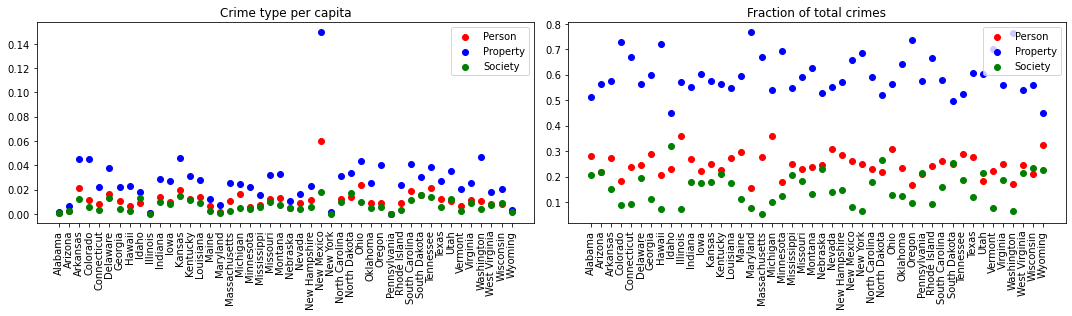

In [14]:
# create a dataframe for percentage of each crime type

crime_type_percentage_df = pd.DataFrame()
crime_type_percentage_df['State'] = featured_df['State']
crime_type_percentage_df['person_crimes_percentage'] = featured_df['person_crimes_per_capita']/featured_df['total_crimes_per_capita']
crime_type_percentage_df['property_crimes_percentage'] = featured_df['property_crimes_per_capita']/featured_df['total_crimes_per_capita']
crime_type_percentage_df['society_crimes_percentage'] = featured_df['society_crimes_per_capita']/featured_df['total_crimes_per_capita']

# visualize the results

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4.5), tight_layout=True)
ax1.scatter(featured_df['State'], featured_df['person_crimes_per_capita'], color='r', label='Person')
ax1.scatter(featured_df['State'], featured_df['property_crimes_per_capita'], color='b', label='Property')
ax1.scatter(featured_df['State'], featured_df['society_crimes_per_capita'], color='g', label='Society')
ax1.legend(loc='upper right')
ax1.set_xticklabels(labels=featured_df['State'], rotation=90)
ax1.set_title('Crime type per capita')

ax2.scatter(crime_type_percentage_df['State'], crime_type_percentage_df['person_crimes_percentage'], color='r', label='Person')
ax2.scatter(crime_type_percentage_df['State'], crime_type_percentage_df['property_crimes_percentage'], color='b', label='Property')
ax2.scatter(crime_type_percentage_df['State'], crime_type_percentage_df['society_crimes_percentage'], color='g', label='Society')
ax2.legend(loc='upper right')
ax2.set_xticklabels(labels=crime_type_percentage_df['State'], rotation=90)
ax2.set_title('Fraction of total crimes')


#### Fraction of different types of crime varies with states. Each type will need a model.

### Apply scaler to the features

In [19]:
featured_df.dtypes

State                          object
population                      int64
total_crimes_per_capita       float64
person_crimes_per_capita      float64
property_crimes_per_capita    float64
society_crimes_per_capita     float64
total_law_per_capita          float64
male_officers_per_capita      float64
female_officers_per_capita    float64
gdp_per_capita                float64
state_size_per_capita         float64
dtype: object

In [152]:
from sklearn.preprocessing import StandardScaler

# Create scaler instance
X_scaler = StandardScaler()

input_columns = ['population',
                'total_law_per_capita',
#                 'male_officers_per_capita',
#                 'female_officers_per_capita',
                'gdp_per_capita',
                'state_size_per_capita']

X = featured_df[input_columns]

# Fit the scaler
X_scaler.fit(X)

# Scale the data
scaled_X = X_scaler.transform(X)

pd.DataFrame(scaled_X, columns=input_columns).head()

,population,total_law_per_capita,gdp_per_capita,state_size_per_capita
0,-0.021935,0.764296,-0.770739,-0.361006
1,0.489384,-0.258809,-0.638485,-0.262234
2,-0.396852,0.383736,-0.881620,-0.225582
3,0.161968,0.083123,-0.119941,-0.210904
4,-0.285750,-1.025842,0.250055,-0.541476


In [153]:
scaled_X.shape

(46, 4)

In [154]:
# Total crime rate

y_total = featured_df['total_crimes_per_capita']
y_total.shape

(46,)

### Build regression model to predict "total_crimes_per_capita"

#### simple linear regression

Coefficients: 
 [-0.00078931 -0.00951431  0.01696474  0.01302435]
Intercept: 
 0.045630487983986875
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.54


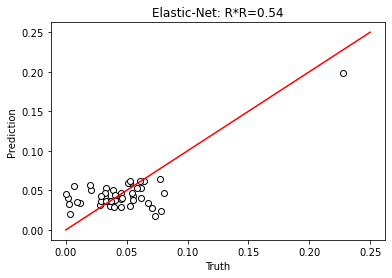

In [155]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

Coefficients: 
 [-0.00078931 -0.00951431  0.01696474  0.01302435]
Intercept: 
 0.045630487983986875
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.54


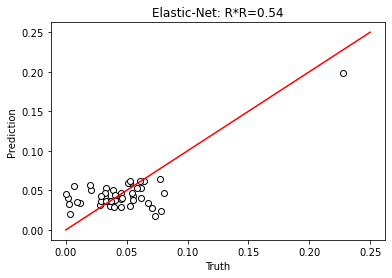

In [161]:
from sklearn.linear_model import TweedieRegressor
reg = TweedieRegressor(power=2, alpha=0.9, link='log')
reg.fit(scaled_X, y_total)
y_total_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

#### Lasso cross-validation: Lasso model reduces the number of sparse (non-zero) coefficients

Alpha hyperparameter:  0.02109382158642447
Coefficients: 
 [-0. -0.  0.  0.]
Intercept: 
 0.04563048798398688
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.00


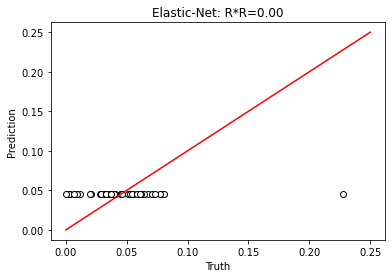

In [144]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score

regr = LassoCV(cv=5, random_state=0)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# The alpha hyperparameter
print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

Coefficients: 
 [-0.         -0.00241887  0.0118249   0.00948236]
Intercept: 
 0.045630487983986875
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.47


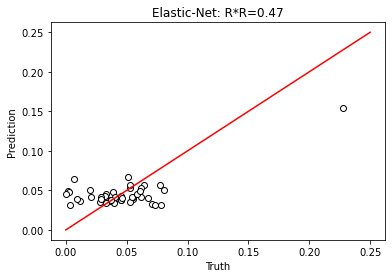

In [149]:
from sklearn.linear_model import Lasso

regr = Lasso(alpha=0.005, random_state=0)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

#### Elastic-Net cross-validation: advantages in regularization and sparse parameters

Alpha hyperparameter:  0.04218764317284895
Coefficients: 
 [-0. -0.  0.  0.]
Intercept: 
 0.04563048798398688
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.00


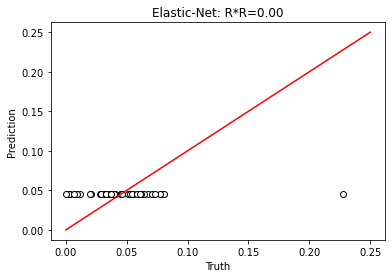

In [133]:
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# The alpha hyperparameter
print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

#### The above two models are affected by the outlier. Try RANSAC (RANdom SAmple Consensus) and Theil-Sen estimator to exclude effect of the outlier.

Mean squared error: 0.00
Coefficient of determination (Rsqured): -0.19


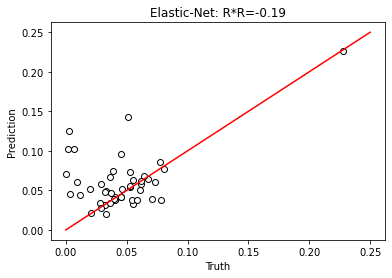

In [134]:
from sklearn.linear_model import RANSACRegressor
# Robustly fit linear model with RANSAC algorithm
ransac = RANSACRegressor()
ransac.fit(scaled_X, y_total)
# inlier_mask = ransac.inlier_mask_
# outlier_mask = numpy.logical_not(inlier_mask)


y_total_pred = ransac.predict(scaled_X)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.41


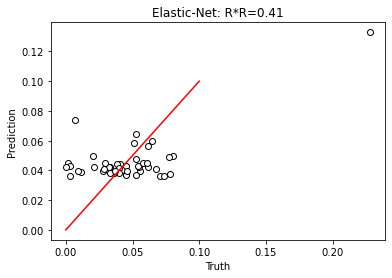

In [135]:
from sklearn.linear_model import TheilSenRegressor
# Robustly fit linear model with  TheilSenRegressor algorithm
thailsen = TheilSenRegressor(random_state=42)
thailsen.fit(scaled_X, y_total)
# inlier_mask = ransac.inlier_mask_
# outlier_mask = numpy.logical_not(inlier_mask)


y_total_pred = thailsen.predict(scaled_X)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.1], [0, 0.1], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

#### Neigher RANSAC (RANdom SAmple Consensus) nor Theil-Sen estimator is able to exclude the effect of the outlier.

#### Examine distribution of the crime types data

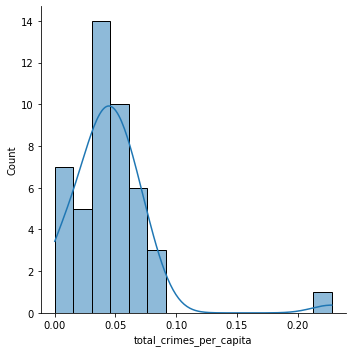

In [81]:
# examine the distribution of y_total dataset

sns.displot(featured_df, 
            x="total_crimes_per_capita", 
            kde=True, 
            )

In [84]:
# remove the outlier from featured_df
new_featured_df = featured_df[featured_df['total_crimes_per_capita'] < 0.2]
new_featured_df.head()

,State,population,total_crimes_per_capita,person_crimes_per_capita,property_crimes_per_capita,society_crimes_per_capita,total_law_per_capita,male_officers_per_capita,female_officers_per_capita,gdp_per_capita,state_size_per_capita
0,Alabama,4851203,0.003216,0.000904,0.001645,0.000667,0.003707,0.002309,0.000209,0.187085,0.010461
1,Arizona,7359580,0.011409,0.002506,0.006425,0.002478,0.003061,0.001537,0.000197,0.203120,0.015441
2,Arkansas,3011972,0.078062,0.021213,0.044990,0.011859,0.003467,0.002021,0.000240,0.173641,0.017289
3,Colorado,5753378,0.061377,0.011162,0.044778,0.005437,0.003277,0.001877,0.000328,0.265989,0.018029
4,Connecticut,3557006,0.032839,0.007825,0.021984,0.003031,0.002576,0.001916,0.000251,0.310849,0.001362


(45, 11)


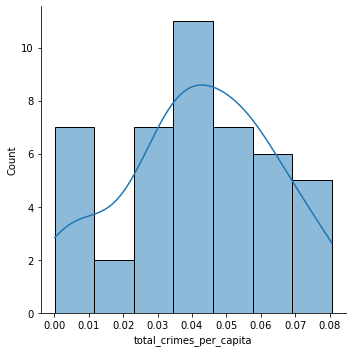

In [86]:
print(new_featured_df.shape)
sns.displot(new_featured_df, 
            x="total_crimes_per_capita", 
            kde=True, 
            )

Alpha hyperparameter:  0.0031097630397845825
Coefficients: 
 [-6.16790569e-19 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]
Intercept: 
 0.04157592888924514
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.00


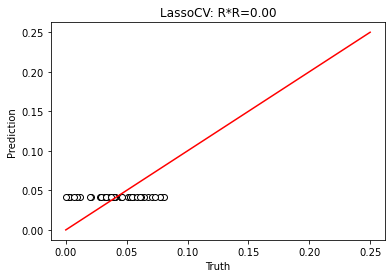

In [136]:
# Create scaler instance
X_scaler = StandardScaler()

input_columns = ['population',
                'total_law_per_capita',
#                 'male_officers_per_capita',
#                 'female_officers_per_capita',
                'gdp_per_capita',
                'state_size_per_capita']

X = new_featured_df[input_columns]

# Fit the scaler
X_scaler.fit(X)

# Scale the data
scaled_X = X_scaler.transform(X)

pd.DataFrame(scaled_X, columns=input_columns).head()

y_total = new_featured_df['total_crimes_per_capita']
y_total.shape

regr = LassoCV(cv=5, random_state=0)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# The alpha hyperparameter
print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("LassoCV: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

Alpha hyperparameter:  0.008297401788043305
Coefficients: 
 [-0. -0. -0. -0.  0. -0.]
Intercept: 
 0.04157592888924514
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.00


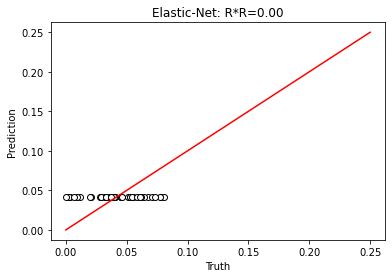

In [93]:
regr = ElasticNetCV(cv=5, random_state=0)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# The alpha hyperparameter
print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

Coefficients: 
 [-0.00486148  0.01039897 -0.01255288 -0.00354855  0.00507558 -0.00450167]
Intercept: 
 0.041575928889245155
Mean squared error: 0.00
Coefficient of determination (Rsqured): 0.11


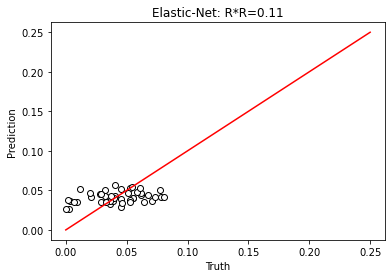

In [97]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(scaled_X, y_total)
regr.fit(scaled_X, y_total)

y_total_pred = regr.predict(scaled_X)

# # The alpha hyperparameter
# print("Alpha hyperparameter: ", regr.alpha_)

# The coefficients
print("Coefficients: \n", regr.coef_)

# The Intercept
print("Intercept: \n", regr.intercept_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_total, y_total_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination (Rsqured): %.2f" % r2_score(y_total, y_total_pred))

# Plot outputs
plt.scatter(y_total, y_total_pred, edgecolors="black", marker='o', color='white')
plt.plot([0, 0.25], [0, 0.25], color="red")

plt.title("Elastic-Net: R*R=%.2f" % r2_score(y_total, y_total_pred))
plt.xlabel("Truth")
plt.ylabel("Prediction")

plt.show()

In [239]:
# select a subset
df = df_0

In [240]:
y = df['crime_to_pop_ratio']
X = df.drop(['crime_to_pop_ratio'], axis=1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

<AxesSubplot:>

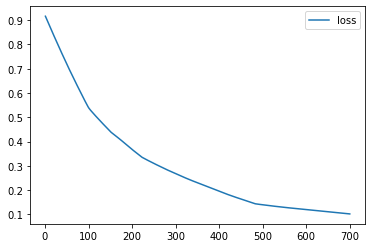

In [241]:
units = 2
activation = 'relu'
epochs = 700


# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=units, activation=activation, input_dim=4))
# nn_model.add(tf.keras.layers.Dense(units=1, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1))

# Check the structure of the Sequential model
# print(nn_model.summary())

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="mean_absolute_error", 
                 optimizer=tf.optimizers.Adam(learning_rate=0.001), 
#                  metrics=["MeanSquaredError"]
                )

# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=epochs, verbose=0)

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")


Text(0.5, 1.0, 'Zoom into Diagnol')

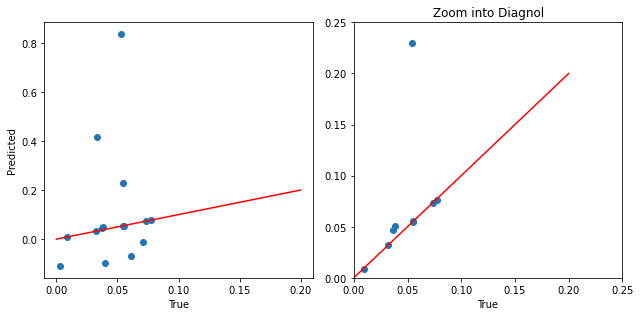

In [242]:
result = pd.DataFrame()
result['True'] = y
result['Predicted'] = nn_model.predict(X_scaler.transform(X))
result.head()

# compare Predicted with True
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
ax1.scatter(result['True'],result['Predicted'])
ax1.plot([0, 0.2], [0, 0.2], 'r')
ax1.set_xlabel('True')
ax1.set_ylabel('Predicted')
ax2.scatter(result['True'], result['Predicted'])
ax2.plot([0, 0.2], [0, 0.2], 'r')
ax2.set_xlim(0, 0.25)
ax2.set_ylim(0, 0.25)
ax2.set_xlabel('True')
ax2.set_title('Zoom into Diagnol')